# RNA Sequence Analysis to detect cancer

---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_classif

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


## 1. Exploratory Data Analysis
Dataset is taken from UCI (https://archive.ics.uci.edu/ml/datasets), It has 802 samples, each sample containing expression values of 
more than 20K genes. Samples are having one of the types of tumor: BRCA, KIRC, COAD, LUAD and PRAD

In [ ]:
rna_exp = pd.read_csv('data.csv', index_col=[0])
labels = pd.read_csv('labels.csv', index_col=[0])

In [ ]:
rna_exp.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [ ]:
labels.head()

,Class
sample_0,PRAD
sample_1,LUAD
sample_2,PRAD
sample_3,PRAD
sample_4,BRCA


In [ ]:
pd.unique(labels.Class)

array(['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'], dtype=object)

Hence total 5 unique cancer type we have to clusterise and categorise.

Different gene expression like gene_0,gene_1 or called levels tells us the variability between different samples, in RNA sequence data analysis, the gene expression value of one sample represents the mean of all expression values of the bulk population of cells.
So if the data have large mean for one of the gene then mean of all the bulk population is also higher and vice-versa.

### Merging both the data

In [ ]:
rna_merged = pd.concat([rna_exp, labels], axis=1)
rna_merged.shape

(801, 20532)

### Hence total unique sample is 801

In [ ]:
exp = rna_merged.set_index('Class').sort_index()

In [ ]:
exp.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
Class,,,,,,,,,,,,,,,,,,,,,
BRCA,0.0,3.801873,5.025591,6.404150,9.564754,0.0,9.997688,1.025241,0.0,0.0,...,5.919628,8.507347,9.849333,8.184360,9.796564,11.607552,10.456272,9.949412,5.980037,0.000000
BRCA,0.0,3.277330,2.629846,6.000487,9.627027,0.0,8.375748,1.029559,0.0,0.0,...,6.152192,9.015499,10.244994,5.172335,9.788066,11.582057,11.098776,9.909158,5.494595,0.000000
BRCA,0.0,1.149975,0.462576,5.861427,10.092440,0.0,5.445833,1.045932,0.0,0.0,...,6.494526,9.549727,10.037602,6.636375,9.459339,10.109922,10.442394,9.574616,3.541862,0.000000
BRCA,0.0,4.538159,3.955722,6.259862,9.103243,0.0,6.918327,1.162726,0.0,0.0,...,7.102994,9.813018,10.629311,7.128757,10.409104,11.195225,11.169593,10.513451,6.729131,0.270828
BRCA,0.0,2.599770,2.562792,7.365491,10.462155,0.0,7.922370,0.000000,0.0,0.0,...,5.036873,8.267555,9.630254,5.531385,9.241642,11.459872,10.045882,9.091528,9.356654,0.000000


In [ ]:
exp.shape

(801, 20531)

Let we check whether we have any null value in data and description which give us more details about it.

In [ ]:
#->
exp.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


So as we can see the data values are ranges from 0 to more than 2 digit magnitude.

In [ ]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, BRCA to PRAD
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5+ MB


In [ ]:
exp.isnull().any().any()

False

Hence no column in the data have any null value

### Plotting our dataset as a hierarchically-clustered heatmap.

Heatmap are easy tools for researchers to look about the features. Our eyes generally gather more attentions to colors rather than numeric data

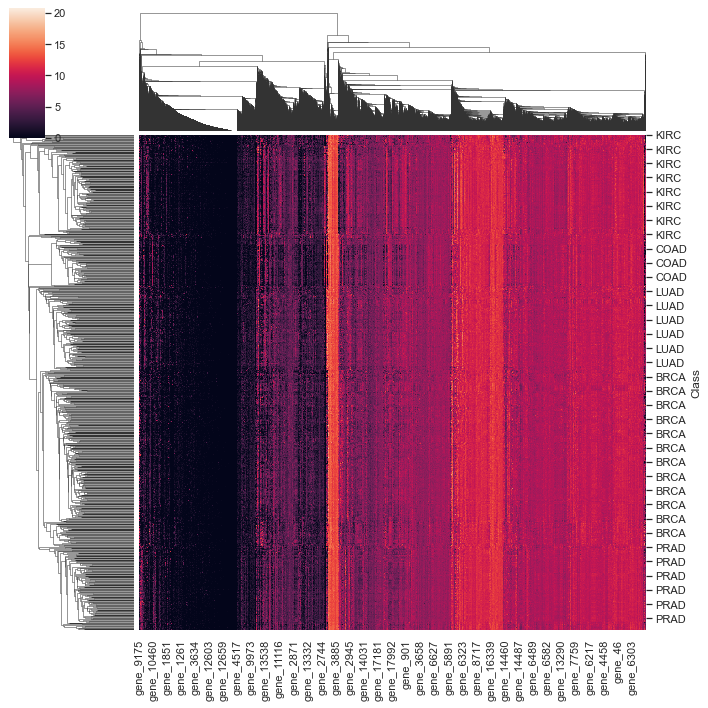

In [ ]:
#->
sns.clustermap(exp)

Text(0.5, 1.0, 'Distribution of label types in Genes data')

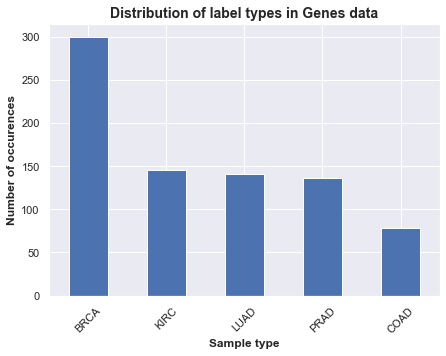

In [ ]:
# visualize distribution of labels
fig = plt.figure(figsize=(7, 5))
exp.index.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Number of occurences', fontsize=12, fontweight='bold')
plt.xlabel('Sample type', fontsize=12, fontweight='bold')
plt.title('Distribution of label types in Genes data', fontsize=14, fontweight='bold')

Hence BRCA occurs the maximum times in our data.

Let we explore the data further by taking transpose of the data we got.

In [ ]:
transpo_exp = exp.T

In [ ]:
transpo_exp.head()

Class,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,...,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD
gene_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.873341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_1,3.801873,3.277330,1.149975,4.538159,2.599770,2.568032,2.522156,2.543372,3.014962,2.215150,...,3.993285,1.978525,1.578649,3.086427,3.579301,3.190172,3.930822,2.676809,1.282262,2.325242
gene_2,5.025591,2.629846,0.462576,3.955722,2.562792,2.891341,2.916821,2.564476,3.355214,1.868845,...,5.367231,3.339465,2.090515,3.006101,3.432706,3.520573,4.049578,3.955629,2.998683,3.805932
gene_3,6.404150,6.000487,5.861427,6.259862,7.365491,7.864793,6.467187,6.299157,6.833712,6.287153,...,6.000973,5.970232,7.194708,6.645314,6.988014,7.210535,6.732256,6.639035,6.342914,6.530246
gene_4,9.564754,9.627027,10.092440,9.103243,10.462155,11.074610,10.010654,9.783317,9.487794,9.273963,...,9.852082,10.688906,10.290940,9.605192,9.470138,9.918593,9.806242,10.301165,9.983649,9.560367


In [ ]:
transpo_exp.info()

In [ ]:
transpo_exp.describe()

Class,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,...,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD
count,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,...,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000
mean,6.557752,6.644628,6.155329,6.626141,6.396475,6.322263,6.288557,6.500574,6.415335,6.479712,...,6.438148,6.412983,6.312476,6.364915,6.651981,6.447557,6.396669,6.492097,6.594778,6.558847
std,3.981935,3.941968,4.187001,3.961697,4.064387,4.110591,4.125778,4.034278,4.069800,4.038053,...,4.038651,4.075581,4.073946,4.092079,3.952284,4.054061,4.051811,4.019520,3.980712,3.978511
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.043939,3.274754,1.645886,3.110881,2.485865,2.293194,2.108239,2.751099,2.535804,2.694769,...,2.605647,2.582965,2.363757,2.388823,3.325127,2.649753,2.506040,2.809517,3.085561,2.968326
50%,7.693717,7.901663,7.365981,7.793863,7.477078,7.383592,7.508714,7.634913,7.662205,7.657597,...,7.525897,7.401332,7.350117,7.458940,7.818825,7.549292,7.456174,7.606139,7.760587,7.735597
75%,9.724256,9.752221,9.631643,9.738612,9.705734,9.683990,9.665126,9.713660,9.676893,9.720757,...,9.706009,9.671866,9.662099,9.689575,9.751830,9.706758,9.670270,9.716877,9.725421,9.707233
max,16.955116,17.170835,17.409996,17.266942,17.242541,17.404551,16.911415,20.778829,17.343698,18.492745,...,18.604495,19.518175,16.354284,19.410091,18.357346,19.469570,18.476703,17.933898,18.059339,16.864488


So the range again of each gene classification expression value from 0 to 20+

## Data Preparation

In [ ]:
features = list(exp.columns.values)
len(features)

20531

In [ ]:
x = rna_exp[features].reset_index(drop=True)
y = labels

In [ ]:
x.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [ ]:
y.index = np.arange(0,801)

we scale our data such that each feature has unit variance. This is necessary because fitting algorithms highly depend on the scaling of the features. Here we use the StandardScaler module for scaling the features individually. StandardScaler subtracts the mean from each feature and then scales to unit variance.

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(x)

In [ ]:
scaled_data

array([[-0.19479935, -0.82802988,  0.15980044, ..., -1.18793812,
        -0.11648251, -0.26190144],
       [-0.19479935, -2.01501735, -1.415042  , ..., -0.34227662,
        -1.65688871, -0.26190144],
       [-0.19479935,  0.41734754,  1.15673547, ...,  0.88686027,
        -1.85526414, -0.26190144],
       ...,
       [-0.19479935,  0.19888076,  0.57481583, ..., -0.22008186,
        -0.41046699,  1.3485582 ],
       [-0.19479935, -0.35045311, -0.28863152, ...,  1.43719268,
         0.09195083, -0.26190144],
       [-0.19479935, -0.57135218,  0.66725377, ...,  0.45087581,
        -0.47161901, -0.26190144]])

**Null Hypothesis testing for few features we have**

We have 5 categories of the output response. Let we test whether the all 5 categories are similar to one another or not based upon the gene expression of our very first 0th column.

In [ ]:
# for this statistical method we will use statsmodel for feature selection using backward elimination
#! pip install statsmodels

In [ ]:
from scipy import stats

In [ ]:
grps = pd.unique(y['Class'])
d_data = {grp:x['gene_0'][y.Class == grp] for grp in grps}

so our data is ready and now let we put 5% threshold that if our p-value comes under 5% we can reject the null hypothesis for gene_0 other-wise we can accept it.

In [ ]:
F, p = stats.f_oneway(d_data['PRAD'], d_data['LUAD'], d_data['BRCA'],d_data['KIRC'],d_data['COAD'])

print("p-value for significance is: ", p)

if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  0.07505540778266195
accept null hypothesis


So we accepting this null hypothesis of all the catories are almost similar which is not true. Hence this gene_0 may not be better fit to classify cancer of the patients.

let we check for gene_1 and gene_2

In [ ]:
d_data = {grp:x['gene_1'][y.Class == grp] for grp in grps}
F, p = stats.f_oneway(d_data['PRAD'], d_data['LUAD'], d_data['BRCA'],d_data['KIRC'],d_data['COAD'])

print("p-value for significance is: ", p)

if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  4.315349359726914e-18
reject null hypothesis


In [ ]:
d_data = {grp:x['gene_2'][y.Class == grp] for grp in grps}
F, p = stats.f_oneway(d_data['PRAD'], d_data['LUAD'], d_data['BRCA'],d_data['KIRC'],d_data['COAD'])

print("p-value for significance is: ", p)

if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  2.1468844023159446e-44
reject null hypothesis


In [ ]:
d_data = {grp:x['gene_3'][y.Class == grp] for grp in grps}
F, p = stats.f_oneway(d_data['PRAD'], d_data['LUAD'], d_data['BRCA'],d_data['KIRC'],d_data['COAD'])

print("p-value for significance is: ", p)

if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  5.472971016870503e-77
reject null hypothesis


*Hence we are getting enough evidence based upon the p-value based upon we can reject the hypothesis that all 5 categories are not similar based upon the evidence we got from gene 1,2,3*

## Task 2: Dimensionality Reduction

**The first method of feature reduction is correlation.** <br>
The correlation is the dependencies in any statistical relationship linearly or non linear. The two columns which are very much collinear like y=2x, in such case both response of our model doesn't get effected even if we remove one of the column.
Let we first see the heatmap of correlation in this data, where the correlation is greater than 0.5

**As our data is quite large in feature it may take several minutes to train get the values** 

In [ ]:
dfCorr = rna_exp.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]

In [ ]:
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

By running this code, we can see the plot having columns which have correlation >=.5 in positive direction like linearly related or inversely.
Once it is done we can remove those feature which have absolute correlation greater than some value threshold like 0.9 

In [ ]:
columns = np.full((filteredDf.shape[0],), True, dtype=bool)
for i in range(filteredDf.shape[0]):
    for j in range(i+1, filteredDf.shape[0]):
        if abs(filteredDf.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = x.columns[columns]
data = x[selected_columns]

**We can also use p-value to select the featres.**<br>
P-value gives us the probability of finding an observation under an assumption that a particular hypothesis is true. This probability is used to accept or reject that hypothesis.

When we remove any feature in dataset the p-value of dataset got effected. We can observe the p-value by removing different features.
The value of feature decide wheather we can keep the feature or not.

In [ ]:
# for our very purpose we will use statsmodels module
import statsmodels.api as sm

In [ ]:
label_encode = LabelEncoder()
encoded_y = label_encode.fit_transform(y)

In [ ]:
selected_columns = exp.columns

def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(scaled_data, encoded_y, SL, selected_columns)

Follwing details we can get:<br>
1) The first hypothesis we can draw, that the combination of the dependent variable doesn't have any effect on dependent variable.<br>
2) Building a regressor and calculated a p-value<br>
3) If the p-value is higher i.e (5%) we discarder the combination.<br>

Let we just start from PCA an unsupervised algorithm followed by LDA which is supervised and we can observe the difference in approach.

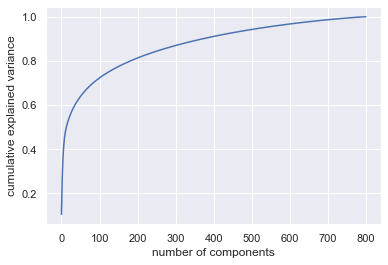

In [ ]:
# In order to find the number of dimensions explaining most of the variety in the data, plot cumulative explained variance
pca_plot = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In order to explain 95% of data, one would need more than 450 principal components.
Hence PCA doesn't seems to be good choice as it need 450+ component to explain the data. For understanding let we reduce dimension and plot data using PCA.

In [ ]:
pca = PCA(n_components=2)
principal_component = pca.fit_transform(x)

In [ ]:
principal_df = pd.DataFrame(data=principal_component, columns=['Principal Component 1', 'Principal Component 2'])

In [ ]:
principal_df.head()

,Principal Component 1,Principal Component 2
0,-62.755415,-94.071973
1,-2.432896,90.585842
2,-71.266853,-8.064608
3,-84.770785,-73.244566
4,-69.560171,-9.612940


In [ ]:
concat_pca_df = principal_df.copy()

In [ ]:
concat_pca_df['Class'] = y['Class']

In [ ]:
concat_pca_df.head()

,Principal Component 1,Principal Component 2,Class
0,-62.755415,-94.071973,PRAD
1,-2.432896,90.585842,LUAD
2,-71.266853,-8.064608,PRAD
3,-84.770785,-73.244566,PRAD
4,-69.560171,-9.612940,BRCA


### Plotting the sample with reduced dimentions

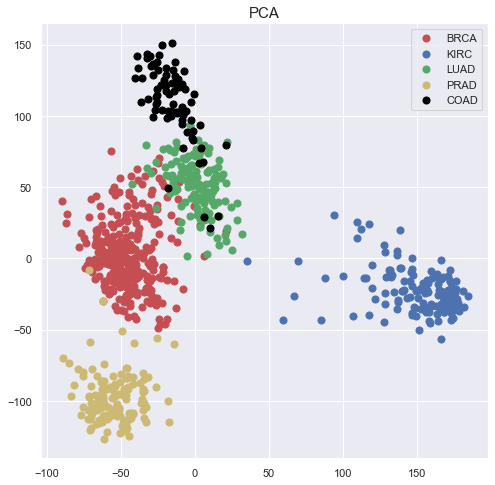

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title('PCA', fontsize=15)
labels_list = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']
colors = ['r', 'b', 'g', 'y', 'black']

for lab, color in zip(labels_list, colors):
    indices = concat_pca_df['Class'] == lab
    ax.scatter(concat_pca_df.loc[indices, 'Principal Component 1'],
              concat_pca_df.loc[indices, 'Principal Component 2'], 
              c = color,
              s = 50)
    ax.legend(labels_list)

Hence PCA is somewhat able to give proper clusters with original. Meanwhile we can also check about PCA with scaled data

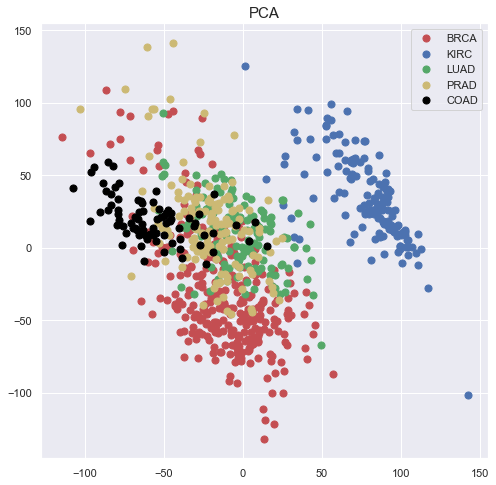

In [ ]:
principal_component_scaled = pca.fit_transform(scaled_data)
principal_scaled_df = pd.DataFrame(data=principal_component_scaled, columns=['Principal Component 1', 'Principal Component 2'])
principal_scaled_df['Class'] = y['Class']
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title('PCA', fontsize=15)
labels_list = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']
colors = ['r', 'b', 'g', 'y', 'black']

for lab, color in zip(labels_list, colors):
    indices = principal_scaled_df['Class'] == lab
    ax.scatter(principal_scaled_df.loc[indices, 'Principal Component 1'],
              principal_scaled_df.loc[indices, 'Principal Component 2'], 
              c = color,
              s = 50)
    ax.legend(labels_list)

Hence PCA is not able to give proper clusters in scaled data

#### 1.3 LDA
Linear Discriminant Analysis

Let we use supervised method to reduced the dimentions of the gene data expressions. Let we use scaled data to fit

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda_rnaexp = lda.fit_transform(scaled_data,y['Class'])

In [ ]:
lda_df = pd.DataFrame(data=lda_rnaexp, columns=['LDA 1', 'LDA 2'])

In [ ]:
lda_df.head()

,LDA 1,LDA 2
0,-7.958125,-10.922818
1,-0.301563,2.780898
2,-6.424952,-8.870978
3,-6.934259,-10.417199
4,-2.872004,4.912284


In [ ]:
lda_concat_df = pd.concat([lda_df, y['Class']], axis=1)

In [ ]:
lda_concat_df.head()

,LDA 1,LDA 2,Class
0,-7.958125,-10.922818,PRAD
1,-0.301563,2.780898,LUAD
2,-6.424952,-8.870978,PRAD
3,-6.934259,-10.417199,PRAD
4,-2.872004,4.912284,BRCA


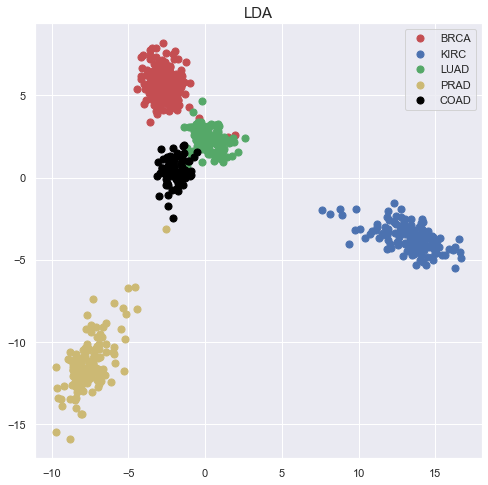

In [ ]:
fig_3 = plt.figure(figsize=(8,8))
ax_3 = fig_3.add_subplot(1,1,1)
ax_3.set_title('LDA', fontsize=15)
labels_list_3 = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']
colors_3 = ['r', 'b', 'g', 'y', 'black']

for lab, color in zip(labels_list_3, colors_3):
    indices_3 = lda_concat_df['Class'] == lab
    ax_3.scatter(lda_concat_df.loc[indices_3, 'LDA 1'],
              lda_concat_df.loc[indices_3, 'LDA 2'], 
              c = color,
              s = 50)
    ax_3.legend(labels_list_3)

## Task 3: Clustering Genes and Samples

1.	Genes whose expression values are similar across all samples

In this we can perform agglomerative hierarchical clustering to plot dendrogram.

In [ ]:
data = x.copy()
data.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


First we will normalize our data

In [ ]:
from sklearn.preprocessing import normalize
norm_data = normalize(data)
norm_data = pd.DataFrame(norm_data, columns=data.columns)
norm_data.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,0.001839,0.002977,0.004994,0.009510,0.0,0.006541,0.000540,0.0,0.0,...,0.004491,0.007485,0.008864,0.006582,0.008314,0.010942,0.008798,0.008133,0.004820,0.0
1,0.0,0.000550,0.001473,0.007037,0.008927,0.0,0.006323,0.000000,0.0,0.0,...,0.004261,0.006794,0.009036,0.005804,0.007775,0.011757,0.009756,0.008718,0.001943,0.0
2,0.0,0.003354,0.004133,0.006572,0.009427,0.0,0.006659,0.000432,0.0,0.0,...,0.004895,0.007762,0.010418,0.005159,0.009466,0.008639,0.009348,0.009637,0.001607,0.0
3,0.0,0.003401,0.004185,0.006182,0.009466,0.0,0.007282,0.000404,0.0,0.0,...,0.005641,0.008163,0.009415,0.008302,0.008913,0.010577,0.009000,0.008991,0.003056,0.0
4,0.0,0.002435,0.002587,0.005995,0.008928,0.0,0.006021,0.000331,0.0,0.0,...,0.005497,0.008152,0.009511,0.006584,0.009028,0.010931,0.008451,0.008674,0.004685,0.0


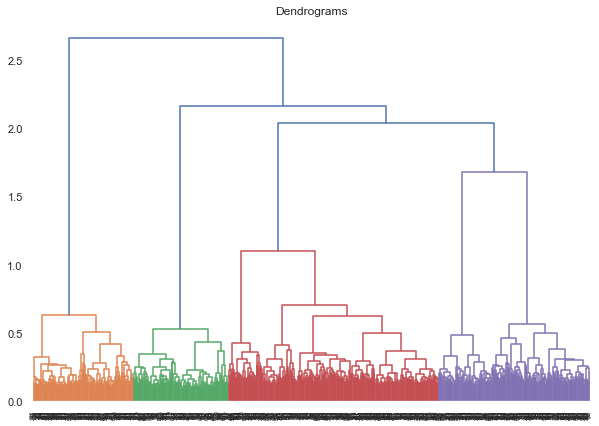

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(norm_data, method='ward'))

Here we got brief details about all the cluster that we can form in it showing gene expression value similar across the whole sample.

At magnitude 1.5 at y-axis let we draw a line parellel to x-axis to see how many cuts we get in dendrogram.

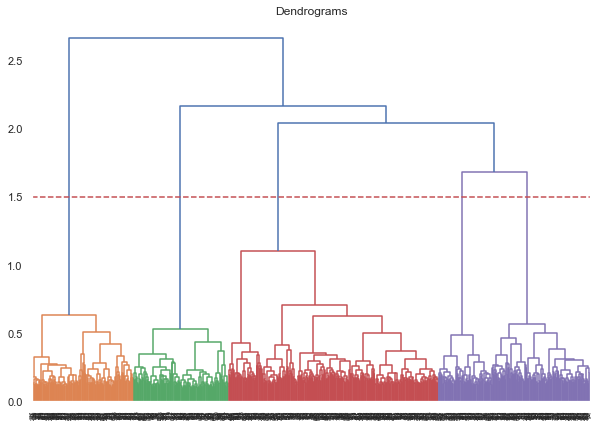

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(norm_data, method='ward'))
plt.axhline(y=1.5, color='r', linestyle='--')

Clearly we can see total 5 cluser we can have from it. <br>
Now let we plot the Agglomerative cluster to get details of Genes whose expression values are similar across samples of each cancer type.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
y_hc = cluster.fit_predict(principal_df)

In [ ]:
pca_df = pd.concat([principal_df,pd.DataFrame(y_hc,columns=['label'])],axis=1)

In [ ]:
pca_df.head()

,Principal Component 1,Principal Component 2,label
0,-62.755415,-94.071973,2
1,-2.432896,90.585842,3
2,-71.266853,-8.064608,0
3,-84.770785,-73.244566,2
4,-69.560171,-9.612940,0


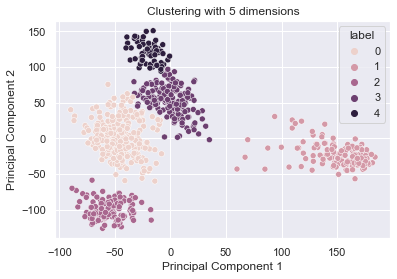

In [ ]:
sns.scatterplot(x="Principal Component 1", y="Principal Component 2", hue=pca_df['label'], data=pca_df)
plt.title('Clustering with 5 dimensions')
plt.show()

Now we apply our clustering technique on samples known as Mean shift clustering which aims to discover “blobs” in a smooth density of samples. It is a centroid-based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region.

In [ ]:
from sklearn.cluster import MeanShift

In [ ]:
ms = MeanShift(bandwidth=35)
ms.fit(principal_df)
centroids = ms.cluster_centers_ 
centroids

array([[ -48.62700841,   -4.77888429],
       [  -2.89619079,   52.28526888],
       [ -55.01100906, -100.47360516],
       [ 159.80946422,  -26.32625709],
       [ -17.86509242,  117.54477594]])

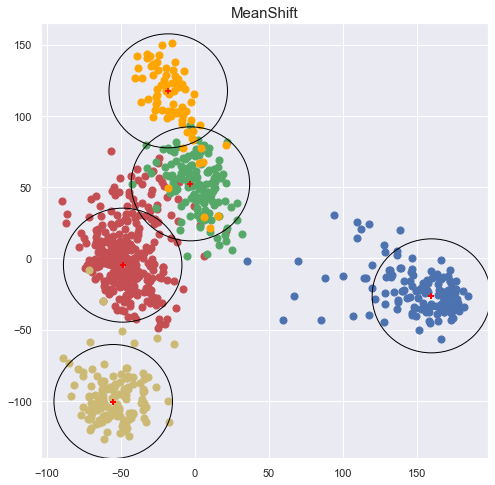

In [ ]:
# Plot the data and centroids
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title('MeanShift', fontsize=15)
labels_list = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']
colors = ['r', 'b', 'g', 'y', 'orange']
for lab, color,center in zip(labels_list, colors,centroids):
    indices = concat_pca_df['Class'] == lab
    ax.scatter(concat_pca_df.loc[indices, 'Principal Component 1'],
              concat_pca_df.loc[indices, 'Principal Component 2'], 
              c = color,
              s = 50)
    ax.scatter(centroids[:,0], centroids[:,1], c='red', marker='+')
    circle = plt.Circle(center, 40, color='black', fill=False, clip_on=True)
    plt.gca().add_artist(circle)

Running k-means algorithm on data using t-SNE dimentions and with original data.

In [ ]:
km_tsne = KMeans(n_clusters = 5, random_state=0)
# predict the cluster labels
y_km = km_tsne.fit_predict(principal_df)
pca_km_df = pd.concat([principal_df,pd.DataFrame(y_km,columns=['label'])],axis=1)
pca_km_df.head()

,Principal Component 1,Principal Component 2,label
0,-62.755415,-94.071973,3
1,-2.432896,90.585842,4
2,-71.266853,-8.064608,0
3,-84.770785,-73.244566,3
4,-69.560171,-9.612940,0


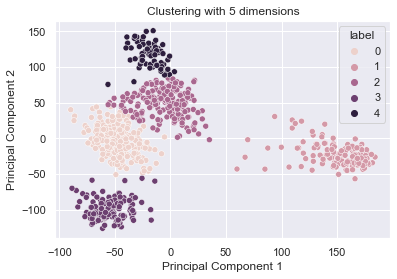

In [ ]:
sns.scatterplot(x="Principal Component 1", y="Principal Component 2", hue=pca_km_df['label'], data=pca_km_df)
plt.title('Clustering with 5 dimensions')
plt.show()

## Task 3: Building Classification models with Feature Selection

In [ ]:
x.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [ ]:
y.head()

,Class
0,PRAD
1,LUAD
2,PRAD
3,PRAD
4,BRCA


1.	Build a classification model/s using multi-class SVM, Random Forest, and Deep Neural Network to classify input data into five cancer types

We dont have to provide all the feature but we can reduce dimentions of the features using PCA

In [ ]:
principal_df.head()

,Principal Component 1,Principal Component 2
0,-62.755415,-94.071973
1,-2.432896,90.585842
2,-71.266853,-8.064608
3,-84.770785,-73.244566
4,-69.560171,-9.612940


For the training we can reduce the number of feature as it gives many key benefits:<br>
**1) Less time to train :** Training is crutial part and if the feature is less it means less time to train.<br>
**2) More accuracy :** Less misleading features in data will direct result in more accurate model.<br>
**3) Less chance of overfitting :** As the hypothesis equation have less dimention once we reduce the feature will direct result in less chance of overfitting.<br>

**Generally dimentionality is reduced in such a way to attain maximum vaiance of data in low dimentions**

## Divinding the dataset into train and test

### Let we divide the data on the give PCA component we got.

In [ ]:
validation_size = 0.15
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(principal_df, y['Class'], test_size=validation_size, random_state=seed)

In [ ]:
X_train.shape

(680, 2)

In [ ]:
import warnings
scoring = 'accuracy'
warnings.filterwarnings(action='ignore', category=UserWarning)

In [ ]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel = 'rbf')))
models.append(('RF',RandomForestClassifier()))

In [ ]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, shuffle = True,random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.958824 (0.025301)
LDA: 0.945588 (0.022830)
KNN: 0.957353 (0.027473)
CART: 0.944118 (0.027747)
NB: 0.944118 (0.024431)
SVM: 0.954412 (0.020217)
RF: 0.960294 (0.026348)


Let we also evaluate the output with deep learning approach by using keras, Please note we use categorical_crossentropy as loss so we have to take dummies of the response that is output data (y)

In [ ]:
Y_train.head()

371    COAD
541    BRCA
728    BRCA
318    KIRC
464    COAD
Name: Class, dtype: object

Since this is multi-class classification so for deep learning we have to make the y value categorical.

In [ ]:
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y = encoder.transform(Y_train)
dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
dummy_y

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=2, activation='relu'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
Y_train.shape

(680,)

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=2, verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
result = cross_val_score(estimator, X_train,dummy_y , cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

Baseline: 90.59% (2.20%)


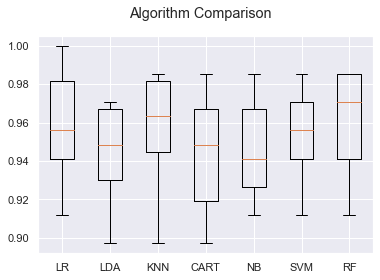

In [ ]:
# Let we compare Algorithms with their results we got
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
len(X_train)

680

***Hence As we compared all the models Random forest is performing well because the mean is as close as we want to get for true result is coming in this model. This model also give less standard deviation hence less deviation in result from the actual mean value as compared to other Algorithms. Based upon these results and observation we can move to select this algorithm for our model***

In [ ]:
# Fitting and predicting using good fit model
classifier = RandomForestClassifier()
classifier.fit(X_train, Y_train)
predictions = classifier.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9173553719008265
[[39  0  0  1  0]
 [ 0 10  0  2  0]
 [ 0  0 18  1  0]
 [ 3  2  0 20  0]
 [ 1  0  0  0 24]]
              precision    recall  f1-score   support

        BRCA       0.91      0.97      0.94        40
        COAD       0.83      0.83      0.83        12
        KIRC       1.00      0.95      0.97        19
        LUAD       0.83      0.80      0.82        25
        PRAD       1.00      0.96      0.98        25

    accuracy                           0.92       121
   macro avg       0.91      0.90      0.91       121
weighted avg       0.92      0.92      0.92       121



In [ ]:
print('Training dataset shape:', X_train.shape, Y_train.shape)
print('Testing dataset shape:', X_validation.shape, Y_validation.shape)

Training dataset shape: (680, 2) (680,)
Testing dataset shape: (121, 2) (121,)


Let we take features of LDA and observe the accuracy.

In [ ]:
X_train_lda = lda_concat_df.iloc[:680,[0,1]]
y_train_lda = lda_concat_df.iloc[:680,2]
X_test_lda = lda_concat_df.iloc[680:,[0,1]]
y_test_lda = lda_concat_df.iloc[680:,2]

In [ ]:
print(len(X_train_lda))
print(len(y_train_lda))
print(len(X_test_lda))
print(len(y_test_lda))

680
680
121
121


In [ ]:
# Fitting and predicting using good fit model
classifier = RandomForestClassifier()
classifier.fit(X_train_lda, y_train_lda)
predictions = classifier.predict(X_test_lda)
print(accuracy_score(y_test_lda, predictions))
print(confusion_matrix(y_test_lda, predictions))
print(classification_report(y_test_lda, predictions))

0.9834710743801653
[[48  0  0  0  0]
 [ 0  8  0  1  0]
 [ 0  0 22  0  0]
 [ 1  0  0 20  0]
 [ 0  0  0  0 21]]
              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        48
        COAD       1.00      0.89      0.94         9
        KIRC       1.00      1.00      1.00        22
        LUAD       0.95      0.95      0.95        21
        PRAD       1.00      1.00      1.00        21

    accuracy                           0.98       121
   macro avg       0.99      0.97      0.98       121
weighted avg       0.98      0.98      0.98       121



**Hence accuracy is clearly very high in LDA for Random Forest model.**

2.	Apply feature selection algorithms such as Forward selection and Backward elimination to refine selected attributes (selected in Task-1) using the above step's classification model.

**The very simple definition of backward elimination is that we take all the columns in focus and keep on removing every columns which doesn't give much insight information to get better response.**
**In forward selection we start from one columns and keep on selecting or increasing the features which give more insight of the data to predict the classification**

The backward elimination have been discussed in above steps

3.	Validate genes selected from the last step using statistical significance testing.

Feature selection method: **SelectKBest**

**Score function:**<br>
For regression: f_regression, mutual_info_regression<br>
For classification: chi2, f_classif, mutual_info_classif<br>

In [ ]:
# example of f-test feature selection for numerical data
validation_size = 0.15
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(x, y['Class'], test_size=validation_size, random_state=seed)

In [ ]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
X_train.shape

(680, 20531)

In [ ]:
# feature selection
X_train_fs, X_validation_fs, fs = select_features(X_train, Y_train, X_validation)

C:\Users\mdrij\.conda\envs\mlenv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Feature 0: 1.297910
Feature 1: 20.156347
Feature 2: 55.841963
Feature 3: 92.192944
Feature 4: 38.031348
Feature 5: nan
Feature 6: 9.657252
Feature 7: 4.142034
Feature 8: 0.663237
Feature 9: 0.967532
Feature 10: 6.698403
Feature 11: 5.858788
Feature 12: 3.494642
Feature 13: 5.476761
Feature 14: 19.498092
Feature 15: 2.625694
Feature 16: 0.807915
Feature 17: 8.210468
Feature 18: 1059.646237
Feature 19: 36.918757
Feature 20: 10.462710
Feature 21: 1.901969
Feature 22: 8.057064
Feature 23: nan
Feature 24: 5.213390
Feature 25: 34.751956
Feature 26: 139.918470
Feature 27: 44.197318
Feature 28: 148.308204
Feature 29: 109.937647
Feature 30: 779.421144
Feature 31: 59.356688
Feature 32: 27.272495
Feature 33: 42.476911
Feature 34: 104.181101
Feature 35: 145.893031
Feature 36: 237.649242
Feature 37: 54.466222
Feature 38: 27.117053
Feature 39: 253.259711
Feature 40: 63.252736
Feature 41: 2.217928
Feature 42: 2.055413
Feature 43: 26.144693
Feature 44: 132.459341
Feature 45: 134.266322
Feature 46: 189

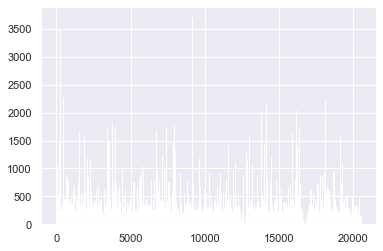

In [ ]:
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

Let we sort the values so that we get best possible features

In [ ]:
top_features = sorted(zip(np.arange(20531), fs.scores_), key=lambda x: x[1], reverse=True)
print(top_features[:50])

[(220, 3517.877503043889), (219, 3339.8938171357613), (450, 2287.3430536815836), (3737, 1810.4960992735332), (3921, 1768.5272405469825), (3439, 1717.2008360489685), (6733, 1683.9114301793488), (1510, 1653.2840829458996), (1858, 1608.789406248699), (3461, 1523.8723969567939), (3523, 1492.785227872033), (11566, 1436.3351516500486), (203, 1413.093901518207), (2288, 1194.7787427361395), (2037, 1185.5061353553842), (18, 1059.6462365856432), (4442, 1040.6621498704571), (11903, 995.9145013762318), (11059, 951.863910854761), (10284, 932.943022790611), (3524, 922.6703172970723), (628, 876.4372246828657), (3970, 866.8123836994073), (2129, 839.5944982350245), (742, 813.2019589796264), (11464, 807.7641235338236), (11910, 782.1129407225955), (3862, 778.2702676796994), (11550, 771.9993363864914), (775, 765.2537294637857), (1482, 749.5911277460859), (5199, 749.4949905930702), (4046, 746.195407135549), (11449, 717.0242974481674), (4223, 707.6563173980221), (2811, 707.138823452797), (1189, 698.45642760